# Main Code

In [6]:
import numpy as np
import random
import time
from IPython.display import clear_output

# Grid environment
GRID_SIZE = 8
START_STATE = (0, 0)
END_STATE = (7, 7)
OBSTACLES = [
    (1, 2), (1, 3), (1, 4),
    (2, 2),
    (3, 4), (3, 5), (3, 6),
    (4, 1), (4, 2),
    (5, 4), (5, 5),
    (6, 6), (6, 7)
]

# Actions (8 directions)
# 0: Up, 1: Down, 2: Left, 3: Right
# 4: Up-Left, 5: Up-Right, 6: Down-Left, 7: Down-Right
ACTIONS = [(0, -1), (0, 1), (-1, 0), (1, 0), (-1, -1), (-1, 1), (1, -1), (1, 1)]
NUM_ACTIONS = len(ACTIONS)

# Initialize Q-table
q_table = np.zeros((GRID_SIZE, GRID_SIZE, NUM_ACTIONS))

# Hyperparameters
LEARNING_RATE = 0.1
DISCOUNT_FACTOR = 0.99
EPSILON = 1.0  # Initial epsilon
EPSILON_DECAY_RATE = 0.9995
MIN_EPSILON = 0.01
TOTAL_EPISODES = 10000

# Rewards
GOAL_REWARD = 100
OBSTACLE_REWARD = -10
DEFAULT_REWARD = -1

def is_valid_state(state):
    row, col = state
    return 0 <= row < GRID_SIZE and 0 <= col < GRID_SIZE and state not in OBSTACLES

def get_next_state(current_state, action_index):
    row, col = current_state
    dr, dc = ACTIONS[action_index]
    next_row, next_col = row + dr, col + dc
    next_state = (next_row, next_col)

    if is_valid_state(next_state):
        return next_state
    else:
        return current_state

def get_reward(state):
    if state == END_STATE:
        return GOAL_REWARD
    elif state in OBSTACLES:
        return OBSTACLE_REWARD
    else:
        return DEFAULT_REWARD

# Q-Learning Training
print("Starting Q-Learning training...")
epsilon = EPSILON

for episode in range(TOTAL_EPISODES):
    current_state = START_STATE
    done = False
    path = []
    total_episode_reward = 0  # Initialize reward for the episode

    while not done:
        row, col = current_state

        # Epsilon-greedy action selection
        if random.uniform(0, 1) < epsilon:
            action_index = random.randint(0, NUM_ACTIONS - 1)  # Explore
        else:
            action_index = np.argmax(q_table[row, col])  # Exploit

        # Get next state and reward
        next_state = get_next_state(current_state, action_index)
        reward = get_reward(next_state)
        total_episode_reward += reward

        # Update Q-table using the Q-Learning formula
        next_row, next_col = next_state
        old_value = q_table[row, col, action_index]
        next_max_value = np.max(q_table[next_row, next_col])
        #new_value = (1 - LEARNING_RATE) * old_value + LEARNING_RATE * (reward + DISCOUNT_FACTOR * next_max_value)
        new_value = old_value + LEARNING_RATE * (reward + DISCOUNT_FACTOR * next_max_value - old_value)
        q_table[row, col, action_index] = new_value

        path.append({'state': current_state, 'action': ACTIONS[action_index], 'chosen_action_index': action_index})

        # Transition to next state
        current_state = next_state

        if current_state == END_STATE:
            done = True


    # Decay epsilon
    epsilon = max(MIN_EPSILON, epsilon * EPSILON_DECAY_RATE)

    # Print Q-table and path every 1000 episodes
    if (episode + 1) % 1000 == 0:
        clear_output(wait=True)
        print(f"Episode: {episode + 1}/{TOTAL_EPISODES}, Total Reward: {total_episode_reward}")
        print(f"Epsilon: {epsilon:.4f}")
        print("\nQ-Table (Average max Q-value per state):")

        # Simplified view of the Q-table
        avg_max_q = np.max(q_table, axis=2).round(2)
        for r in range(GRID_SIZE):
            print(avg_max_q[r])

        print("\nPath for this episode:")
        for step in path[:10] + (path[-10:] if len(path) > 20 else []): # Print first and last few steps
            print(f"  Agent at {step['state']} chose action {step['action']} (index {step['chosen_action_index']})")
        if len(path) > 20:
            print("  ...")

        print("-" * 30)

print("Training finished.")

# Choose the action with the highest Q-value
print("\nFinding optimal path using the trained Q-table:")
current_state = START_STATE
optimal_path = []
while current_state != END_STATE:
    row, col = current_state
    action_index = np.argmax(q_table[row, col])
    action = ACTIONS[action_index]
    optimal_path.append({'state': current_state, 'action': action, 'chosen_action_index': action_index})
    current_state = get_next_state(current_state, action_index)
    # Add a safety break
    if len(optimal_path) > GRID_SIZE * GRID_SIZE * 2:
        print("Could not find path or stuck in loop.")
        break

optimal_path.append({'state': END_STATE, 'action': None, 'chosen_action_index': None}) # Add the final state

for step in optimal_path:
  if 'action'==None:
    print(f"  Agent at {step['state']} (Goal reached!)")
  else:
    print(f"  Agent at {step['state']} chose action {step['action']}")

# Optimal path on the grid
grid_display = np.zeros((GRID_SIZE, GRID_SIZE), dtype=str)
for r in range(GRID_SIZE):
    for c in range(GRID_SIZE):
        if (r, c) == START_STATE:
            grid_display[r, c] = 'S'
        elif (r, c) == END_STATE:
            grid_display[r, c] = 'E'
        elif (r, c) in OBSTACLES:
            grid_display[r, c] = '#'
        else:
            grid_display[r, c] = '.'

# Mark the optimal path
for step in optimal_path[:-1]:
    row, col = step['state']
    if grid_display[row, col] == '.':
         grid_display[row, col] = '*'

print("\nOptimal Path Visualization:")
for row in grid_display:
    print(" ".join(row))

Episode: 10000/10000, Total Reward: 92
Epsilon: 0.0100

Q-Table (Average max Q-value per state):
[84.55 84.55 84.55 84.55 86.41 86.41 86.41 86.38]
[86.41 86.41  0.    0.    0.   88.3  88.3  88.3 ]
[86.41 88.3   0.   88.3  88.3  88.3  90.2  90.2 ]
[86.41 88.3  90.2  90.2   0.    0.    0.   92.12]
[88.3   0.    0.   92.12 92.12 94.06 94.06 94.06]
[88.3  90.2  92.12 94.06  0.    0.   96.02 94.06]
[88.3  90.2  92.12 94.06 96.02 98.    0.    0.  ]
[ 88.3   90.2   92.12  94.06  96.02  98.   100.     0.  ]

Path for this episode:
  Agent at (0, 0) chose action (1, 0) (index 3)
  Agent at (1, 0) chose action (1, 1) (index 7)
  Agent at (2, 1) chose action (1, 1) (index 7)
  Agent at (3, 2) chose action (1, 1) (index 7)
  Agent at (4, 3) chose action (1, 0) (index 3)
  Agent at (5, 3) chose action (1, 1) (index 7)
  Agent at (6, 4) chose action (0, 1) (index 1)
  Agent at (6, 5) chose action (1, 1) (index 7)
  Agent at (7, 6) chose action (0, 1) (index 1)
------------------------------
Training

# Visualize learning progress

Episode: 10000/10000, Total Reward: 92
Epsilon: 0.0100

Q-Table (Average max Q-value per state):
[84.55 84.55 84.55 84.55 86.41 86.41 86.41 86.41]
[86.41 86.41  0.    0.    0.   88.3  88.3  88.3 ]
[86.41 88.3   0.   88.3  88.3  88.3  90.2  90.2 ]
[86.41 88.3  90.2  90.2   0.    0.    0.   92.12]
[88.3   0.    0.   92.12 92.12 94.06 94.06 94.06]
[88.3  90.2  92.12 94.06  0.    0.   96.02 94.06]
[88.3  90.2  92.12 94.06 96.02 98.    0.    0.  ]
[ 88.3   90.2   92.12  94.06  96.02  98.   100.     0.  ]

Path for this episode:
  Agent at (0, 0) chose action (1, 0) (index 3)
  Agent at (1, 0) chose action (1, 1) (index 7)
  Agent at (2, 1) chose action (1, 1) (index 7)
  Agent at (3, 2) chose action (1, 1) (index 7)
  Agent at (4, 3) chose action (1, 0) (index 3)
  Agent at (5, 3) chose action (1, 1) (index 7)
  Agent at (6, 4) chose action (0, 1) (index 1)
  Agent at (6, 5) chose action (1, 1) (index 7)
  Agent at (7, 6) chose action (0, 1) (index 1)
------------------------------
Training

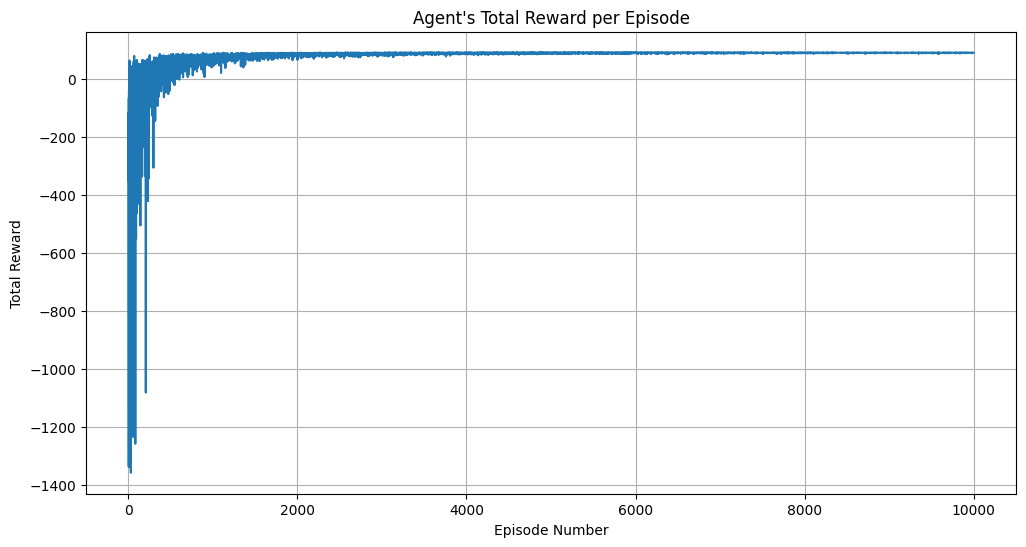


Finding optimal path using the trained Q-table:
  Agent at (0, 0) chose action (1, 0)
  Agent at (1, 0) chose action (1, 1)
  Agent at (2, 1) chose action (1, 1)
  Agent at (3, 2) chose action (1, 1)
  Agent at (4, 3) chose action (1, 0)
  Agent at (5, 3) chose action (1, 1)
  Agent at (6, 4) chose action (0, 1)
  Agent at (6, 5) chose action (1, 1)
  Agent at (7, 6) chose action (0, 1)
  Agent at (7, 7) (Goal reached!)

Optimal Path Visualization:
S . . . . . . .
* . # # # . . .
. * # . . . . .
. . * . # # # .
. # # * . . . .
. . . * # # . .
. . . . * * # #
. . . . . . * E


In [8]:
# Q-Learning Training
print("Starting Q-Learning training...")
epsilon = EPSILON
episode_rewards = []

for episode in range(TOTAL_EPISODES):
    current_state = START_STATE
    done = False
    path = []
    total_episode_reward = 0  # Initialize reward for the episode

    while not done:
        row, col = current_state

        # Epsilon-greedy action selection
        if random.uniform(0, 1) < epsilon:
            action_index = random.randint(0, NUM_ACTIONS - 1)  # Explore
        else:
            action_index = np.argmax(q_table[row, col])  # Exploit

        # Get next state and reward
        next_state = get_next_state(current_state, action_index)
        reward = get_reward(next_state)
        total_episode_reward += reward  # Total reward

        # Update Q-table using the Q-Learning formula
        next_row, next_col = next_state
        old_value = q_table[row, col, action_index]
        next_max_value = np.max(q_table[next_row, next_col])
        new_value = old_value + LEARNING_RATE * (reward + DISCOUNT_FACTOR * next_max_value - old_value)
        q_table[row, col, action_index] = new_value

        # Record the step
        path.append({'state': current_state, 'action': ACTIONS[action_index], 'chosen_action_index': action_index})

        current_state = next_state

        if current_state == END_STATE:
            done = True


    # Decay epsilon
    epsilon = max(MIN_EPSILON, epsilon * EPSILON_DECAY_RATE)

    # Append the total reward for this episode
    episode_rewards.append(total_episode_reward)

    # Print Q-table and path
    if (episode + 1) % 1000 == 0:
        clear_output(wait=True)
        print(f"Episode: {episode + 1}/{TOTAL_EPISODES}, Total Reward: {total_episode_reward}")
        print(f"Epsilon: {epsilon:.4f}")
        print("\nQ-Table (Average max Q-value per state):")

        avg_max_q = np.max(q_table, axis=2).round(2)
        for r in range(GRID_SIZE):
            print(avg_max_q[r])

        print("\nPath for this episode:")
        for step in path[:10] + (path[-10:] if len(path) > 20 else []): # Print first and last few steps
            print(f"  Agent at {step['state']} chose action {step['action']} (index {step['chosen_action_index']})")
        if len(path) > 20:
            print("  ...")

        print("-" * 30)

print("Training finished.")

# Plot the total reward per episode
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(range(1, TOTAL_EPISODES + 1), episode_rewards)
plt.xlabel("Episode Number")
plt.ylabel("Total Reward")
plt.title("Agent's Total Reward per Episode")
plt.grid(True)
plt.show()


print("\nFinding optimal path using the trained Q-table:")
current_state = START_STATE
optimal_path = []
while current_state != END_STATE:
    row, col = current_state
    action_index = np.argmax(q_table[row, col])
    action = ACTIONS[action_index]
    optimal_path.append({'state': current_state, 'action': action, 'chosen_action_index': action_index})
    current_state = get_next_state(current_state, action_index)
    # Add a safety break
    if len(optimal_path) > GRID_SIZE * GRID_SIZE * 2:
        print("Could not find path or stuck in loop.")
        break

optimal_path.append({'state': END_STATE, 'action': None, 'chosen_action_index': None}) # Add the final state

for step in optimal_path:
  if step['action'] is None:
    print(f"  Agent at {step['state']} (Goal reached!)")
  else:
    print(f"  Agent at {step['state']} chose action {step['action']}")

# Optimal path on the grid
grid_display = np.zeros((GRID_SIZE, GRID_SIZE), dtype=str)
for r in range(GRID_SIZE):
    for c in range(GRID_SIZE):
        if (r, c) == START_STATE:
            grid_display[r, c] = 'S'
        elif (r, c) == END_STATE:
            grid_display[r, c] = 'E'
        elif (r, c) in OBSTACLES:
            grid_display[r, c] = '#'
        else:
            grid_display[r, c] = '.'

# Mark the optimal path
for step in optimal_path[:-1]:
    row, col = step['state']
    if grid_display[row, col] == '.':
         grid_display[row, col] = '*'

print("\nOptimal Path Visualization:")
for row in grid_display:
    print(" ".join(row))

## Experiment with hyperparameters

### Subtask:
Run the training process with different combinations of these hyperparameters and for each combination, record the learning progress (e.g., final average reward, convergence speed).


In [3]:
# Define hyperparameter combinations to experiment with
hyperparameter_combinations = [
    {'LEARNING_RATE': 0.1, 'DISCOUNT_FACTOR': 0.99, 'EPSILON_DECAY_RATE': 0.9995}, # Original
    {'LEARNING_RATE': 0.5, 'DISCOUNT_FACTOR': 0.99, 'EPSILON_DECAY_RATE': 0.9995}, # Higher Learning Rate
    {'LEARNING_RATE': 0.1, 'DISCOUNT_FACTOR': 0.9, 'EPSILON_DECAY_RATE': 0.9995},  # Lower Discount Factor
    {'LEARNING_RATE': 0.1, 'DISCOUNT_FACTOR': 0.99, 'EPSILON_DECAY_RATE': 0.9},   # Faster Epsilon Decay
    {'LEARNING_RATE': 0.05, 'DISCOUNT_FACTOR': 0.95, 'EPSILON_DECAY_RATE': 0.999} # Different combination
]

# List to store results for each combination
experiment_results = []

# Iterate through each hyperparameter combination
for params in hyperparameter_combinations:
    print(f"Running experiment with: {params}")

    # Set hyperparameters for the current experiment
    LEARNING_RATE = params['LEARNING_RATE']
    DISCOUNT_FACTOR = params['DISCOUNT_FACTOR']
    EPSILON_DECAY_RATE = params['EPSILON_DECAY_RATE']
    epsilon = EPSILON

    # Re-initialize Q-table
    q_table = np.zeros((GRID_SIZE, GRID_SIZE, NUM_ACTIONS))

    episode_rewards = []

    # Q-Learning Training
    for episode in range(TOTAL_EPISODES):
        current_state = START_STATE
        done = False
        total_episode_reward = 0

        while not done:
            row, col = current_state

            # Epsilon-greedy action selection
            if random.uniform(0, 1) < epsilon:
                action_index = random.randint(0, NUM_ACTIONS - 1)  # Explore
            else:
                action_index = np.argmax(q_table[row, col])  # Exploit

            # Get next state and reward
            next_state = get_next_state(current_state, action_index)
            reward = get_reward(next_state)
            total_episode_reward += reward

            # Update Q-table using the Q-Learning formula
            next_row, next_col = next_state
            old_value = q_table[row, col, action_index]
            next_max_value = np.max(q_table[next_row, next_col])
            new_value = old_value + LEARNING_RATE * (reward + DISCOUNT_FACTOR * next_max_value - old_value)
            q_table[row, col, action_index] = new_value

            # Transition to the next state
            current_state = next_state

            # Check if goal is reached
            if current_state == END_STATE:
                done = True

        # Decay epsilon
        epsilon = max(MIN_EPSILON, epsilon * EPSILON_DECAY_RATE)

        # Append the total reward for this episode
        episode_rewards.append(total_episode_reward)

    # Store the results for this hyperparameter combination
    experiment_results.append({
        'hyperparameters': params,
        'episode_rewards': episode_rewards
    })

    print("Experiment finished.")



Running experiment with: {'LEARNING_RATE': 0.1, 'DISCOUNT_FACTOR': 0.99, 'EPSILON_DECAY_RATE': 0.9995}
Experiment finished.
Running experiment with: {'LEARNING_RATE': 0.5, 'DISCOUNT_FACTOR': 0.99, 'EPSILON_DECAY_RATE': 0.9995}
Experiment finished.
Running experiment with: {'LEARNING_RATE': 0.1, 'DISCOUNT_FACTOR': 0.9, 'EPSILON_DECAY_RATE': 0.9995}
Experiment finished.
Running experiment with: {'LEARNING_RATE': 0.1, 'DISCOUNT_FACTOR': 0.99, 'EPSILON_DECAY_RATE': 0.9}
Experiment finished.
Running experiment with: {'LEARNING_RATE': 0.05, 'DISCOUNT_FACTOR': 0.95, 'EPSILON_DECAY_RATE': 0.999}
Experiment finished.


## Analyze and compare results

### Subtask:
Compare the learning curves and performance metrics from the different hyperparameter settings to understand their impact.


**Reasoning**:
Plot the learning curves for each hyperparameter combination and analyze the results.



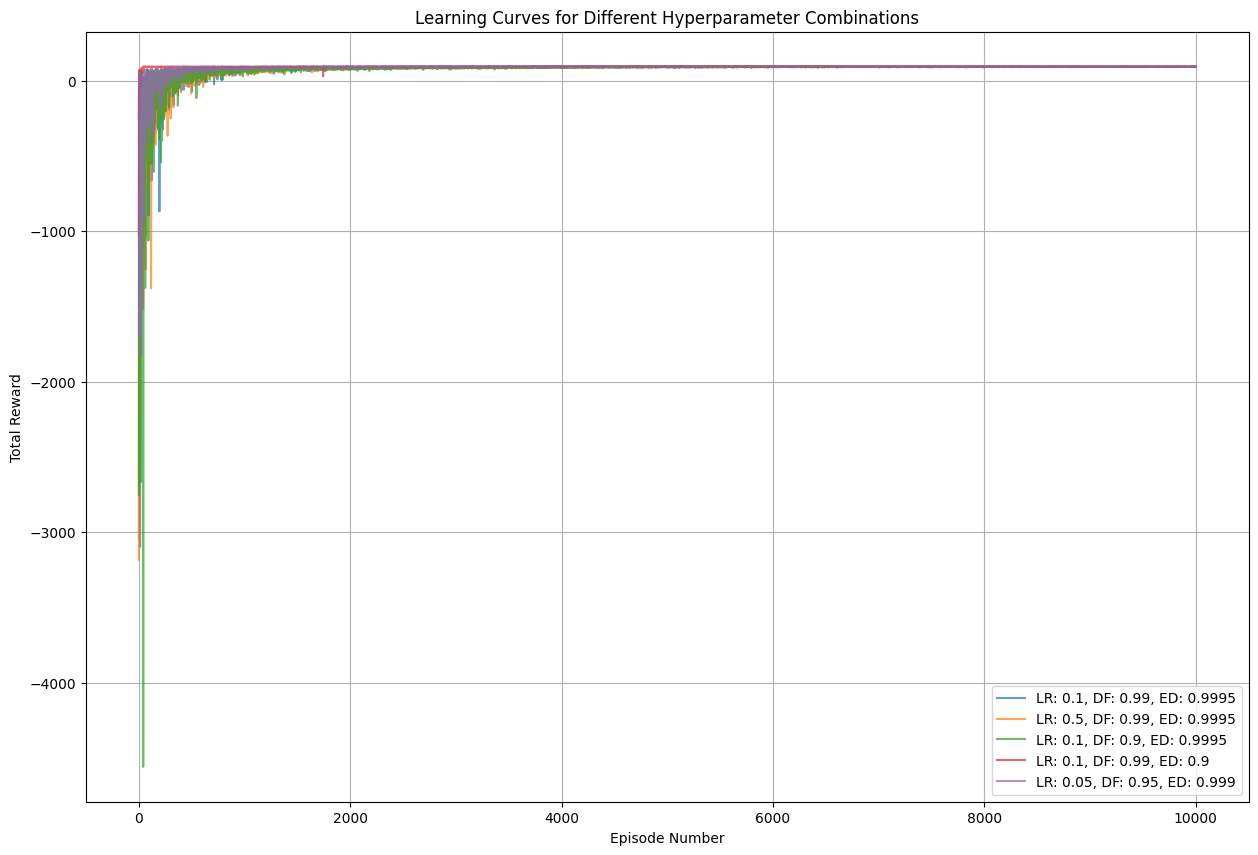


--- Analysis of Learning Curves ---

LR: 0.1, DF: 0.99, ED: 0.9995:
  Average reward over last 1000 episodes: 91.91

LR: 0.5, DF: 0.99, ED: 0.9995:
  Average reward over last 1000 episodes: 91.89

LR: 0.1, DF: 0.9, ED: 0.9995:
  Average reward over last 1000 episodes: 91.87

LR: 0.1, DF: 0.99, ED: 0.9:
  Average reward over last 1000 episodes: 91.89

LR: 0.05, DF: 0.95, ED: 0.999:
  Average reward over last 1000 episodes: 91.89


In [9]:
import matplotlib.pyplot as plt

# Plotting the learning curves for each experiment
plt.figure(figsize=(15, 10))

for result in experiment_results:
    hyperparams = result['hyperparameters']
    rewards = result['episode_rewards']
    label = f"LR: {hyperparams['LEARNING_RATE']}, DF: {hyperparams['DISCOUNT_FACTOR']}, ED: {hyperparams['EPSILON_DECAY_RATE']}"
    plt.plot(range(1, TOTAL_EPISODES + 1), rewards, label=label, alpha=0.7)

plt.xlabel("Episode Number")
plt.ylabel("Total Reward")
plt.title("Learning Curves for Different Hyperparameter Combinations")
plt.legend()
plt.grid(True)
plt.show()

# Analyze the plots and performance metrics
print("\n--- Analysis of Learning Curves ---")

for result in experiment_results:
    hyperparams = result['hyperparameters']
    rewards = result['episode_rewards']
    label = f"LR: {hyperparams['LEARNING_RATE']}, DF: {hyperparams['DISCOUNT_FACTOR']}, ED: {hyperparams['EPSILON_DECAY_RATE']}"

    # Calculate average reward over the last N episodes (e.g., last 1000 episodes)
    N = 1000
    if len(rewards) >= N:
        average_final_reward = np.mean(rewards[-N:])
        print(f"\n{label}:")
        print(f"  Average reward over last {N} episodes: {average_final_reward:.2f}")
    else:
        print(f"\n{label}:")
        print(f"  Not enough episodes ({len(rewards)}) to calculate average reward over last {N}.")
